## Deep Autoencoder

Multiple dense layers for encoder and decoder

! final model is very big (GB), BREAKS when total parameters > 400 million!

### Set environment

In [1]:
!pip install tensorflow-gpu

In [0]:
#from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, BatchNormalization, Activation
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

from PIL import Image

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Build model architecture 

In [0]:
dim_orig_flat = 256 * 256 * 3
dim_layer_1 = 256 # 1024, 256, for first layer
#dim_layer_2 = 288 # 512, 128, for second layer
dim_latent = 128 # 256, 64, for latent space, ultimate compression


In [5]:
input_img = Input(shape=(256, 256, 3)) 

x = Flatten()(input_img)

# add the BN transform immediately before the nonlinearity (orig paper)
# 'Accelerating Deep Network Training by Reducing Internal Covariate Shift.'
# exampe:
# model.add(layers.Dense(64, use_bias=False))
# model.add(layers.BatchNormalization())
# model.add(Activation("relu"))

x = Dense(dim_layer_1,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

# x = Dense(dim_layer_2,use_bias=False)(x)
# x = BatchNormalization()(x)
# x = Activation("relu")(x)

encoded = Dense(dim_latent, activation = 'relu')(x)

encoder = Model(input_img, encoded)
# encoder.summary()

# x = Dense(dim_layer_2,use_bias=False)(encoded)
# x = BatchNormalization()(x)
# x = Activation("relu")(x)

x = Dense(dim_layer_1,use_bias=False)(encoded)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Dense(dim_orig_flat,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("sigmoid")(x)

decoded = Reshape((256, 256, 3))(x)
  
deep_AE = Model(input_img, decoded)

deep_AE.compile(optimizer = 'rmsprop', loss = 'mean_squared_error') # try: loss = 'binary_crossentropy'

deep_AE.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               50331648  
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               3276

### Generate images

In [0]:
image_data_dir = '/content/drive/My Drive/PhenoCAT/labeled_images'
image_size = 256 # All images will be resized to 
batch_size = 10

In [7]:
# Rescale and augment
datagen = image.ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 180,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)
# results in tuples of (x, y) where x is a numpy array containing a batch of images 
# with shape (batch_size, *target_size, channels) 
# and y is a numpy array of corresponding labels.
train_generator = datagen.flow_from_directory(image_data_dir,                      
                                                target_size = (image_size, image_size), # default: 256
                                                color_mode='rgb', 
                                                batch_size = batch_size,
                                                class_mode = 'input', # when images identical to input images (autoencoders)
                                                # save_to_dir = 'path' saves augmented images 
                                                # save_prefix='augm_', 
                                                # save_format='png', 
                                                subset='training') # 'validation'
                   

validation_generator = datagen.flow_from_directory(image_data_dir,
                                                target_size = (image_size, image_size), # default: 256
                                                color_mode='rgb', 
                                                batch_size = batch_size, 
                                                class_mode = 'input',
                                                # save_to_dir = 'path' saves augmented images 
                                                # save_prefix='augm_', 
                                                # save_format='png', 
                                                subset='validation') # 'validation'


Found 2055 images belonging to 1 classes.
Found 513 images belonging to 1 classes.


### Train model

In [8]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size
epochs = 50

print(steps_per_epoch,validation_steps)

205 51


In [9]:
history = deep_AE.fit_generator(train_generator,
                                    steps_per_epoch = steps_per_epoch,
                                    epochs = epochs,
                                    validation_data = validation_generator,
                                    validation_steps = validation_steps)

# save model and architecture to single file
deep_AE.save("/content/drive/My Drive/Model_data/Deep_AE_v4.h5")
encoder.save("/content/drive/My Drive/Model_data/Deep_AE_v4_encoder.h5")

print("Saved model and weights")

Epoch 1/50
205/205 [==============================] - 48s 236ms/step - loss: 0.2292 - val_loss: 0.5963
Epoch 2/50
205/205 [==============================] - 44s 213ms/step - loss: 0.1977 - val_loss: 0.1999
Epoch 3/50
205/205 [==============================] - 43s 211ms/step - loss: 0.1703 - val_loss: 0.1489
Epoch 4/50
205/205 [==============================] - 43s 212ms/step - loss: 0.1484 - val_loss: 0.1111
Epoch 5/50
205/205 [==============================] - 43s 211ms/step - loss: 0.1255 - val_loss: 0.0691
Epoch 6/50
205/205 [==============================] - 43s 212ms/step - loss: 0.0913 - val_loss: 0.0627
Epoch 7/50
205/205 [==============================] - 43s 209ms/step - loss: 0.0663 - val_loss: 0.0634
Epoch 8/50
205/205 [==============================] - 43s 210ms/step - loss: 0.0476 - val_loss: 0.0397
Epoch 9/50
205/205 [==============================] - 43s 211ms/step - loss: 0.0337 - val_loss: 0.0297
Epoch 10/50
205/205 [==============================] - 43s 210ms/step - l

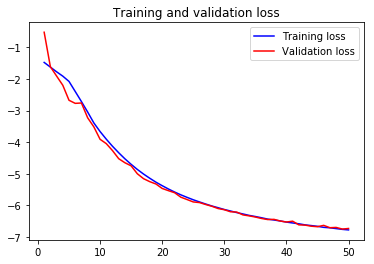

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']


x_epochs = range(1,epochs+1)

plt.figure()
plt.plot(x_epochs, np.log(loss), 'b', label = 'Training loss')
plt.plot(x_epochs, np.log(val_loss), 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.show()

plt.savefig('/content/drive/My Drive/Model_data/Loss_curve_Deep_AE_v4.pdf')

### Plot 5 images

In [11]:
num_images = 5
image_shape = (256, 256, 3)

path_to_folder = '/content/drive/My Drive/PhenoCAT/labeled_images/labeled_loose/'

image_list = os.listdir(path_to_folder)

image_list[0]

'CN-CP613_J06_T0001F020L01A01Z01C01_094.png'

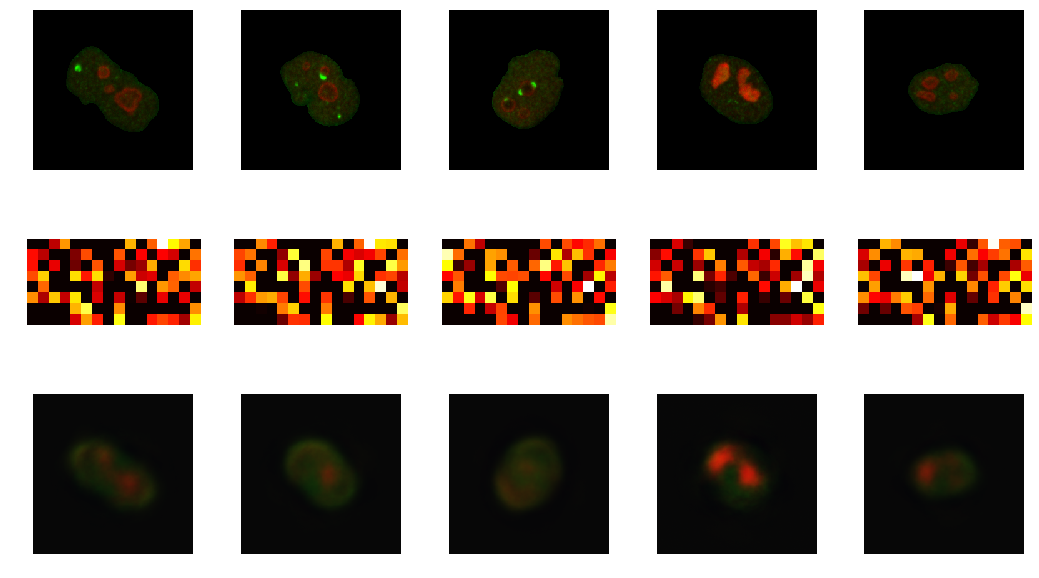

In [13]:
random_int = np.random.randint(0, len(image_list), num_images)


plt.figure(figsize=(18, 10))

for i in range(0, len(random_int)):
    curr_int = random_int[i]
    
    im_name = image_list[curr_int]
    im_path = path_to_folder + im_name
    real_image = image.load_img(im_path)

    img_tensor = image.img_to_array(real_image)/255
    img_tensor_ex = np.expand_dims(img_tensor, axis = 0)
    encoded_img = encoder.predict(img_tensor_ex) 
    new_im_size = int(np.sqrt(encoded_img.shape[1]))
    latent_image = encoded_img.reshape(8, 16) 
   
    decoded_image_ex = deep_AE.predict(img_tensor_ex)
    decoded_image = np.squeeze(decoded_image_ex, axis = 0)
    
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(real_image)
    plt.axis('off') # ax.get_xaxis().set_visible(False)
    
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(latent_image, cmap = 'hot')
    plt.axis('off') # ax.get_xaxis().set_visible(False)
    
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_image)
    plt.axis('off') # ax.get_xaxis().set_visible(False)


